# EE219 Project 3

### Team members:
* **Yin Fei** 404284074

* **Yichen Wu** 504294181

* **Siyuan Chen** 405024391

* **Ruchen Zhen** 205036408

### Required Packages:
python 3.6
numpy v1.14.0  
scikit-learn v0.19.1  
scipy v1.0.0  
matplotlib v2.1.2  
pandas v0.22.0   
surprise v0.1  
scikit-surprise v1.0.5


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging
import pickle
import os
from logging.config import fileConfig

# create logger
fileConfig('logging_config.ini')
logger = logging.getLogger()
logger.setLevel("WARNING")
# logger.setLevel("INFO")

GET_DATA_FROM_FILES = True

# load data
r_data = pd.read_csv('data/ratings.csv', header=0, usecols=[0, 1, 2])
print(r_data.head())
R = r_data.pivot_table(index='userId', columns='movieId', 
                       values='rating').values
print("(number of users, number of rated movies): ", R.shape)


   userId  movieId  rating
0       1       31     2.5
1       1     1029     3.0
2       1     1061     3.0
3       1     1129     2.0
4       1     1172     4.0
(number of users, number of rated movies):  (671, 9066)


#### Question 1

In [17]:
# Question 1
user_count = R.shape[0]
movie_count = R.shape[1]
max_rating_count = user_count*movie_count
rating_count = len(r_data.rating.tolist())
sparsity = rating_count*1.0/max_rating_count
print("Matrix sparsity = %0.4f" % sparsity)

Matrix sparsity = 0.0164


#### Question 2

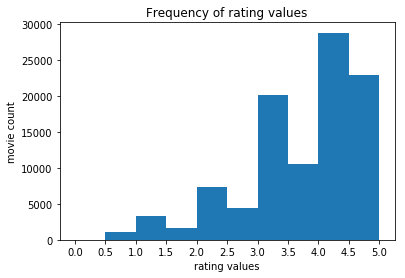

In [18]:
# Question 2
plt.figure()
ax = plt.subplot(111)
ratings = r_data.rating.tolist()
xrange = np.arange(0, 5.5, 0.5)
ax.hist(ratings, bins=xrange)
ax.set_xticks(xrange)
ax.set_title("Frequency of rating values")
ax.set_xlabel("rating values")
ax.set_ylabel("movie count")
plt.show()

#### Question 3

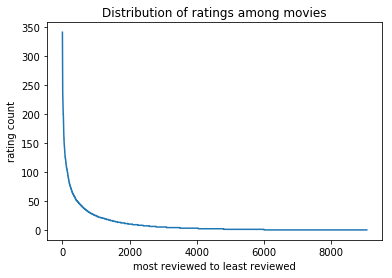

In [19]:
# Question 3
plt.figure()
movie_rating_count = np.count_nonzero(~np.isnan(R), axis=0)
sorted_mrc = sorted(movie_rating_count, reverse=True)
ax = plt.subplot(111)
ax.plot(range(len(movie_rating_count)), sorted_mrc, '-')
ax.set_title("Distribution of ratings among movies")
ax.set_xlabel("most reviewed to least reviewed")
ax.set_ylabel("rating count")
plt.show()

#### Question 4

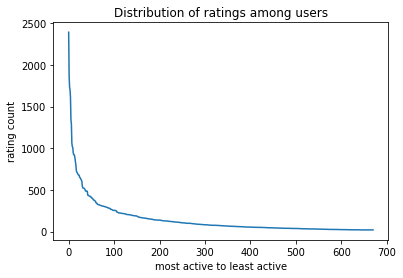

In [20]:
# Question 4
plt.figure()
user_rating_count = np.count_nonzero(~np.isnan(R), axis=1)
sorted_urc = sorted(user_rating_count, reverse=True)
ax = plt.subplot(111)
ax.plot(range(len(user_rating_count)), sorted_urc, '-')
ax.set_title("Distribution of ratings among users")
ax.set_xlabel("most active to least active")
ax.set_ylabel("rating count")
plt.show()

#### Question 5
ToDo: Explain the salient features of the distribution found in question 3 and their implications for the recommendation process.

#### Question 6

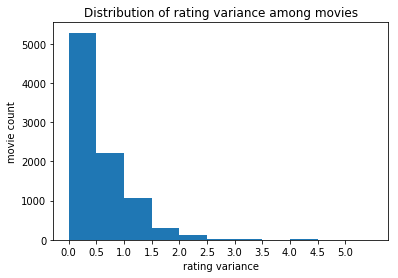

In [21]:
# Question 6
plt.figure()
ax = plt.subplot(111)
movie_var = np.nanvar(R, axis=0)
var_range = np.arange(min(movie_var), max(movie_var)+0.5, 0.5)
ax.hist(movie_var, bins=var_range)
ax.set_xticks(xrange)
ax.set_title("Distribution of rating variance among movies")
ax.set_xlabel("rating variance")
ax.set_ylabel("movie count")
plt.show()

#### Question 7

$I_u$ : Set of item indices for which ratings have been specifed by user $u$  
$I_v$ : Set of item indices for which ratings have been specifed by user $v$  
$\mu_u$ : Mean rating for user $u$ computed using her specifed ratings  
$r_{uk}$ : Rating of user $u$ for item $k$  

$$\mu_u = \frac{\Sigma_{i\in I_{u}} r_{ui}}{\mid I_u \mid}$$

#### Question 8

$I_{u} \cap I_{v}$ represents the indices of movies that are rated by both user $u$ and user $v$. It's possible that this intersection be the empty set ($\emptyset$), given the sparsity of the matrix. It happens when user $u$ has not rated any movie that user $v$ has.

#### Question 9

#### Question 10

In [22]:
import surprise
from surprise import Dataset
from surprise.model_selection import cross_validate
data = Dataset.load_builtin('ml-100k')

k_lst = range(2,101,2)

sim_options = {'name': 'pearson'}
rmse_lst=[]
mae_lst=[]

if GET_DATA_FROM_FILES and os.path.isfile("./rmse_lst.pkl")\
                    and os.path.isfile("./mae_lst.pkl"):
    logging.info("Loading rmse_lst and mae_lst.")
    rmse_lst = pickle.load(open("./rmse_lst.pkl", "rb"))
    mae_lst = pickle.load(open("./mae_lst.pkl", "rb"))
else:
    for k in k_lst:
        algo = surprise.prediction_algorithms.knns.KNNWithMeans(k=k, sim_options=sim_options)
        result = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10)
        rmse_lst.append(np.mean(result['test_rmse']))
        mae_lst.append(np.mean(result['test_mae']))
    
    pickle.dump(rmse_lst, open("./rmse_lst.pkl", "wb"))    
    pickle.dump(mae_lst, open("./mae_lst.pkl", "wb"))

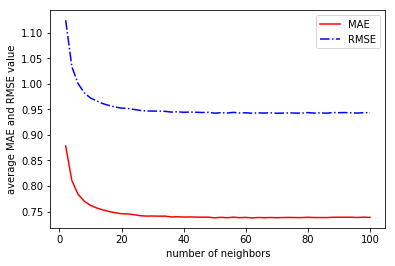

In [23]:
l1, = plt.plot(k_lst, mae_lst, 'r-', label='MAE')
l2, = plt.plot(k_lst, rmse_lst, 'b-.', label='RMSE')
plt.xlabel('number of neighbors')
plt.ylabel('average MAE and RMSE value')
plt.legend(handles=[l1, l2])
plt.show()

#### Question 11

The minimum $k$ is about __12__. MAE converges to __0.74__ and RMSE converges to __0.94__.

#### Question 12,13,14

In [24]:
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import KFold

In [25]:
def trim_popular(testset):
    trimmed = []
    mat = np.array(testset, dtype=[('u', int), ('m', int), ('r', float)])
    mat.sort(order='m')
    counter = 0
    lastm = mat[0][1]
    for u, m, r in mat:
        if m != lastm:
            if counter <= 2:
                for i in range(counter):
                    trimmed.pop(-1)

            counter = 0
            lastm = m
        
        counter += 1
        trimmed.append((u, m, r))

    if counter <= 2:
        for i in range(counter):
            trimmed.pop(-1)

    return trimmed

In [26]:
def trim_unpopular(testset):
    trimmed = []
    mat = np.array(testset, dtype=[('u', int), ('m', int), ('r', float)])
    mat.sort(order='m')
    counter = 0
    lastm = mat[0][1]
    for u, m, r in mat:
        if m != lastm:
            if counter > 2:
                for i in range(counter):
                    trimmed.pop(-1)

            counter = 0
            lastm = m
        
        counter += 1
        trimmed.append((u, m, r))

    if counter > 2:
        for i in range(counter):
            trimmed.pop(-1)

    return trimmed

In [27]:
def trim_highvar(testset):
    trimmed = []
    mat = np.array(testset, dtype=[('u', int), ('m', int), ('r', float)])
    mat.sort(order='m')
    counter = 0
    temp_r = []
    lastm = mat[0][1]
    for u, m, r in mat:
        if m != lastm:
            if counter < 5 or np.var(temp_r) < 2:
                for i in range(counter):
                    trimmed.pop(-1)

            counter = 0
            temp_r = []
            lastm = m
        
        counter += 1
        temp_r.append(r)
        trimmed.append((u, m, r))

    if counter < 5 or np.var(temp_r) < 2:
        for i in range(counter):
            trimmed.pop(-1)

    return trimmed

In [28]:
#test block
ratings_dict = {'userID': [9, 32, 2, 45, 4, 1, 5, 31, 21],
                'itemID': [1, 1, 1, 1, 1, 1, 1, 2, 2],
                'rating': [3.5, 2.5, 4.0, 1, 1, 1, 1, 3.5, 1.0]}
df1 = pd.DataFrame(ratings_dict)
reader1 = Reader(rating_scale=(1, 5))
# The columns must correspond to user id, item id and ratings (in that order).
data1 = Dataset.load_from_df(df1[['userID', 'itemID', 'rating']], reader1)

kf1 = KFold(n_splits=2)
for trainset, testset in kf1.split(data1):
    print(trim_popular(testset))

[(1, 1, 1.0), (5, 1, 1.0), (9, 1, 3.5), (32, 1, 2.5)]
[(2, 1, 4.0), (4, 1, 1.0), (45, 1, 1.0)]


In [29]:
kf = KFold(n_splits=10)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(r_data[['userId', 'movieId', 'rating']], reader)

rmse_pop = []
rmse_unpop = []
rmse_highvar = []

if GET_DATA_FROM_FILES and os.path.isfile("./rmse_pop.pkl")\
                    and os.path.isfile("./rmse_unpop.pkl")\
                    and os.path.isfile("./rmse_highvar.pkl"):
    logging.info("Loading rmse_pop, rmse_unpop and rmse_highvar.")
    rmse_pop = pickle.load(open("./rmse_pop.pkl", "rb"))
    rmse_unpop = pickle.load(open("./rmse_unpop.pkl", "rb"))
    rmse_highvar = pickle.load(open("./rmse_highvar.pkl", "rb"))
else:
    for k in k_lst:
        rmse_temp_pop = []
        rmse_temp_unpop = []
        rmse_temp_highvar = []
        algo = surprise.prediction_algorithms.knns.KNNWithMeans(k=k, sim_options=sim_options)
        for trainset,testset in kf.split(data):
            algo.fit(trainset)
            predictions_pop = algo.test(trim_popular(testset))
            predictions_unpop = algo.test(trim_unpopular(testset))
            predictions_highvar = algo.test(trim_highvar(testset))
            rmse_temp_pop.append(accuracy.rmse(predictions_pop))
            rmse_temp_unpop.append(accuracy.rmse(predictions_unpop))
            rmse_temp_highvar.append(accuracy.rmse(predictions_highvar))
        rmse_pop.append(np.mean(rmse_temp_pop))
        rmse_unpop.append(np.mean(rmse_temp_unpop))
        rmse_highvar.append(np.mean(rmse_temp_highvar))

    pickle.dump(rmse_pop, open("./rmse_pop.pkl", "wb"))    
    pickle.dump(rmse_unpop, open("./rmse_unpop.pkl", "wb"))
    pickle.dump(rmse_highvar, open("./rmse_highvar.pkl", "wb"))

print(rmse_pop[:5])

[1.0474940413149139, 0.95481980124888055, 0.92194934099151138, 0.90665093687839526, 0.89817706028640032]


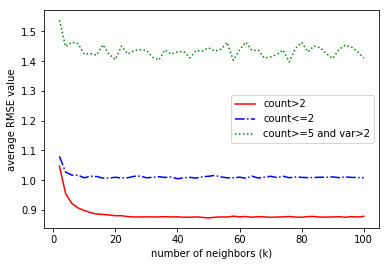

In [30]:
l1, = plt.plot(k_lst, rmse_pop, 'r-', label='count>2')
l2, = plt.plot(k_lst, rmse_unpop, 'b-.', label='count<=2')
l3, = plt.plot(k_lst, rmse_highvar, 'g:', label='count>=5 and var>2')
plt.xlabel('number of neighbors (k)')
plt.ylabel('average RMSE value')
plt.legend(handles=[l1, l2, l3])
plt.show()

#### Question 15

Computing the pearson similarity matrix...
Done computing similarity matrix.


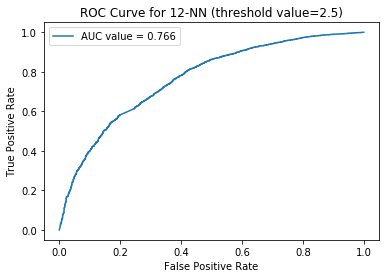

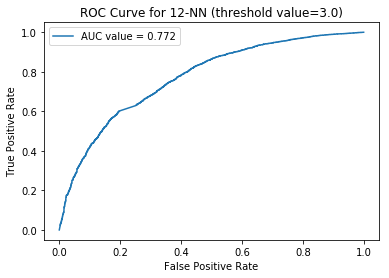

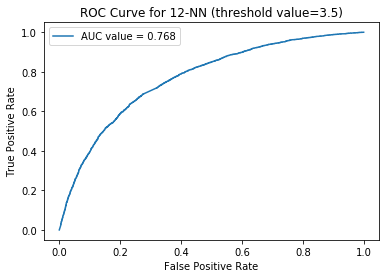

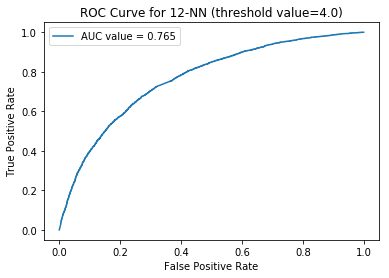

In [82]:
from sklearn import metrics
from surprise.model_selection import train_test_split
mink=12
thresholdlist=[2.5, 3, 3.5, 4]
algo = surprise.prediction_algorithms.knns.KNNWithMeans(k=mink, sim_options=sim_options)
trainset, testset = train_test_split(data, test_size=.1)
algo.fit(trainset)
pred=algo.test(testset)
for ths in thresholdlist:
    y_true=[]
    y_pred=[]
    for _,_,r_real,r_pred,_ in pred:
        if r_real >= ths:
            y_true.append(1)
        else:
            y_true.append(0)
        y_pred.append(r_pred)
    fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
    plt.plot(fpr, tpr, label='AUC value = %0.3f' % metrics.roc_auc_score(y_true=y_true, y_score=y_pred))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for 12-NN (threshold value=%.1f)' % ths)
    plt.legend()
    plt.show()